In [1]:
from __future__ import print_function, division
from nilmtk import DataSet, HDFDataStore, TimeFrame
from os.path import join
import matplotlib.pyplot as plt
from matplotlib import rcParams
import math
from nilmtk.metrics import f1_score # metrics is actually different; need to look at this
from nilmtk.metrics import rms_error_power
from nilmtk.metrics import mean_normalized_error_power
from nilmtk.disaggregate import fhmm_exact # OK, only different in what is printed to screen (and this is diagonal covariance matrix)


/opt/conda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
building_number = 1
ds = DataSet('/nilmtk/data/iawe.h5') #('/nilmtk/data/ukdale.h5') #("/data/REDD/redd.h5")
print(ds.buildings)

OrderedDict([(1, Building(instance=1, dataset='iAWE'))])


In [3]:
train = DataSet('/nilmtk/data/iawe.h5') #('/nilmtk/data/ukdale.h5') #("/data/REDD/redd.h5")
test = DataSet('/nilmtk/data/iawe.h5') #('/nilmtk/data/ukdale.h5') #("/data/REDD/redd.h5")

In [4]:
elec = train.buildings[building_number].elec

In [5]:
mains = elec.mains()
df_all = mains.power_series_all_data() #df_all has a bunch of NaNs
df_all_noNan = df_all.dropna()
a = df_all_noNan.keys()
middleTime = a[int(math.floor(a.size/2))]
middleTimeStr = "%d-%02d-%02d %02d:%02d:%02d" % (middleTime.year, middleTime.month, middleTime.day, middleTime.hour, middleTime.minute, middleTime.second)

Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.


In [7]:
middleTimeStr

'2013-07-01 02:23:50'

In [8]:
train.set_window(end=middleTimeStr)
test.set_window(start=middleTimeStr)

train_elec = train.buildings[building_number].elec
test_elec = test.buildings[building_number].elec

top_train_elec = train_elec.submeters().select_top_k(k=5)

10/10 ElecMeter(instance=12, building=1, dataset='iAWE', appliances=[Appliance(type='motor', instance=1)])

In [9]:
fhmm = fhmm_exact.FHMM() #mk change this later  to default
fhmm.train(top_train_elec, sample_period=60, resample=True)
outputAddress = "/nilmtk/data/iawe_449_4.h5"
output = HDFDataStore(outputAddress, 'w')
fhmm.disaggregate(test_elec.mains(), output, sample_period=60, resample=True)
output.close()

Training model for submeter 'ElecMeter(instance=7, building=1, dataset='iAWE', appliances=[Appliance(type='computer', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=2)])'
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='iAWE', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=1, dataset='iAWE', appliances=[Appliance(type='television', instance=1)])'
Loading data for meter ElecMeterID(instance=1, building=1, dataset='iAWE')     

/nilmtk/nilmtk/metergroup.py:901: UserWarning: As a quick implementation we only get Good Sections from the first meter in the meter group.  We should really return the intersection of the good sections for all meters.  This will be fixed...
  warn("As a quick implementation we only get Good Sections from"


Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.


In [10]:
%matplotlib inline

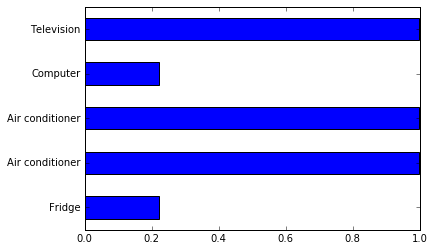

In [11]:
disag = DataSet(outputAddress) #load FHMM prediction
disag_elec = disag.buildings[building_number].elec
#disag_elec.plot() # plot all disaggregated data
f1 = f1_score(disag_elec, test_elec)
f1.index = disag_elec.get_labels(f1.index)
f1.plot(kind='barh')

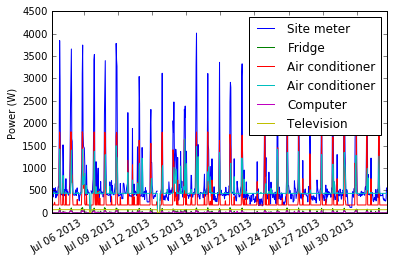

In [26]:
disag.store.window = TimeFrame(start='2013-07-02 18:00:00-05:00', end='2013-08-01 04:00:00-05:00')
disag.buildings[building_number].elec.plot() # plot all disaggregated data


In [27]:
rms = rms_error_power(disag_elec, test_elec)

In [28]:
rms

3      74.161928
4     443.171610
5     614.412107
7      35.627620
10      3.404301
dtype: float64

In [29]:
mne = mean_normalized_error_power(disag_elec, test_elec)

In [30]:
mne

3     0.954806
4     0.117448
5     0.397077
7     0.978287
10    0.043665
dtype: float64